In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    roc_curve, auc,
    precision_recall_curve,
    precision_score, recall_score, f1_score,accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC ,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

import numpy as np

<h2 style="text-align: center;">Instituto Superior de Engenharia de Lisboa</h2>  
<h3 style="text-align: center;">Licenciatura em Engenharia Informática e Multimédia</h3>
<p  style="margin-top:20px;text-align: center;">Aprendizagem Automática</p>
<p  style="text-align: center;">Semestre de Inverno 2024/2025</p>
<p  style="text-align: center;">2º Trabalho Prático</p>
<p  style="text-align: center;">Trabalho realizado por: </p>
<div style="margin:auto; display:flex"> 
    <ul style="margin:auto; display:block">
        <li>Alice Fernandes, Aluna Nº 45741</li>
        <li>Guilherme Mendes, Aluno Nº 49718</li>
        <li>Bruno Antunes, Aluno Nº 49755</li>
    </ul>
</div>

# 1 - Introdução




# 2 - Desenvolvimento


## 2.1 - Transformação de dados com TF-IDF

limpeza dos textos (HTML, regex, min_df, etc.),

seleção de parâmetros do TfidfVectorizer (ex.: min_df, max_df, ngram_range, token_pattern, stop_words, norm, etc.),

evitar vocabulários demasiado grandes (afetam desempenho e overfitting).


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import pickle
from nltk.stem import  LancasterStemmer, PorterStemmer

# carregar dados
D = pickle.load(open("imdbFull.p", "rb"))
data = D["data"]
labels = D["target"]

#data = data[0:5000] # TODO: Remove this when pickling the final data
#labels = labels[0:5000]

def clean_text(t):
    t = t.replace("<br />", " ")                  
    t = re.sub(r"[^a-zA-Z]+", " ", t)             
    t = t.lower()
    return t

def apply_stemming(text, stemmer):
    return " ".join(stemmer.stem(word) for word in text.split())

def clean_dataset(data, stemmer):
    X_clean = []
    
    for t in data:
        cleaned = clean_text(t)
        cleaned = apply_stemming(cleaned, stemmer)
        X_clean.append(cleaned)
    
    return X_clean



In [4]:
# transformar em 0 e 1
y_bin = np.where(labels < 5, 0, 1)

# dividir dados
X_train, X_test, y_train, y_test = train_test_split(
    data, y_bin, test_size=0.25, random_state=42, stratify=y_bin
)

lancaster = LancasterStemmer()
porter = PorterStemmer()

lr = LogisticRegression(max_iter=2000, random_state=42)
svm = LinearSVC(random_state=42)

# parâmetros TF-IDF a testar
min_dfs = [3, 5] # min_dfs ->  used for removing terms that appear too infrequently
max_dfs = [0.5, 0.75] # max_df ->  used for removing terms that appear too frequently
max_features = [1000, 5000] # max_features ->  used for limiting the number of features
stop_words_list = [None, "english"] # stop_words_list ->  used for removing stop words
token_patterns = [r"[a-zA-Z]{3,}", r"[a-zA-Z]{4,}"]
ngrams = [(1,2)] # ngrams -> configures the n-grams
classifiers = [lr]
stemmers = [lancaster, porter] # stemmers ->  used for stemming the text

results = []

def run_combination(X_train, X_test, stemmer, min_df, max_df, sw, tp,ng,max_feature):
    print("Combo: ", stemmer, min_df,  sw, tp,ng,max_feature)
    X_train_clean = clean_dataset(X_train, stemmer) 
    X_test_clean = clean_dataset(X_test, stemmer)
    
    # criar TF-IDF para esta combinação
    vectorizer = TfidfVectorizer(
        min_df=min_df,
        max_df=max_df,
        stop_words=sw,
        token_pattern=tp,
        ngram_range=ng,
        max_features=max_feature,
    )
    metrics = []
    
    # aplicar TF-IDF
    Xtr = vectorizer.fit_transform(X_train_clean)
    Xts = vectorizer.transform(X_test_clean)
    
    for classifier in classifiers:
        classifier.fit(Xtr, y_train)
        pred_lr = classifier.predict(Xts)
        metrics.append(accuracy_score(y_test, pred_lr))
    
    media = np.sum(metrics) / len(metrics)
    media_geo = np.sqrt(np.prod(metrics)) # maioritariamente parecida com a outra
    
    print(f"Stemmer={stemmer} | MEDIA={media} | MEDIA GEO={media_geo}") # ordenar por performance da SVM
    return vectorizer, stemmer, media, media_geo

"""
# Sequencialmente
for stemmer in stemmers:
    for max_feature in max_features:
        for min_df in min_dfs:
            for sw in stop_words_list:
                for tp in token_patterns:
                    for ng in ngrams:
                        run_combination(X_train, X_test, stemmer, min_df, sw, tp, ng, max_feature)
"""

def parallel_tfidf(data, use_pickled=False):
    fname = "data_clean.pkl"
    
    if(use_pickled):
        vectorizer, cleaned_data = pickle.load(open(fname, 'rb'))
        return vectorizer, cleaned_data, 

    total = len(max_dfs) * len(min_dfs) * len(max_features) * len(stop_words_list) * len(token_patterns) * len(ngrams) * len(stemmers) * len(classifiers)
    print(f"Combinações: {total}")


    # Paralelo
    all_combinations = [
        (X_train, X_test,stemmer,min_df,max_df,sw,tp,ng,max_feature)
        for stemmer in stemmers
        for min_df in min_dfs
        for max_df in max_dfs
        for sw in stop_words_list
        for tp in token_patterns
        for ng in ngrams
        for max_feature in max_features
    ]
    
    # 2.4 minutos (96 * 2 combos)
    results = Parallel(n_jobs=8, verbose=10)(
        delayed(run_combination)(*combo) for combo in all_combinations
    )

    sorted_results = sorted(results, key=lambda x: x[3], reverse=True)
    
    vectorizer, stemmer, media, media_geo = sorted_results[0]
    cleaned_data = clean_dataset(data, stemmer)
    
    print("Final Combo", stemmer, vectorizer)
    
    file = open(fname, 'wb')
    pickle.dump((vectorizer,cleaned_data), file)
    return vectorizer, cleaned_data

vectorizer, cleaned_data = parallel_tfidf(data, use_pickled=True)
print(cleaned_data[0][:1000])
print(vectorizer)



zero day lead you to think even re think whi two boy young men would do what they did commit mutual suicid via slaughter their classmat it captur what must be beyond a bizarr mode of be for two human who have decid to withdraw from common civil in order to defin their own mutual world via coupl destruct it is not a perfect movi but given what money time the filmmak and actor had it is a remark product in term of explain the motiv and action of the two young suicid murder it is better than eleph in term of be a film that get under our rationalist skin it is a far far better film than almost anyth you are like to see flaw but honest with a terribl honesti
TfidfVectorizer(max_df=0.75, max_features=5000, min_df=5, ngram_range=(1, 2),
                token_pattern='[a-zA-Z]{3,}')


C:\Users\alice\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\alice\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 2.2 - Treino de Classificadores 
- train/test split com estratificação,
- k-fold cross validation, StratifiedKFold,

- análise de métricas: matriz de confusão, recall, precision.



In [ ]:
# regressor linear com test train split e idf
# exemplo feito durante a aula só para referencia para a malta. Usar o vectorizer de cima
"""
X_train, X_test, y_train, y_test = train_test_split(Docs, y, test_size=1/3, random_state=42)

# transform train e test
X_train_idf = vectorizer.transform(X_train)
X_test_idf = vectorizer.transform(X_test)

# regressor linear
lr = LogisticRegression(max_iter=1000)

# fit
lr.fit(X_train_idf, y_train)

# predict
lr.predict(X_test_idf)
"""

'\nX_train, X_test, y_train, y_test = train_test_split(Docs, y, test_size=1/3, random_state=42)\n\n# fit no train\nidf = TfidfVectorizer(min_df=5).fit(X_train)\n\n# transform train e test\nX_train_idf = idf.transform(X_train)\nX_test_idf = idf.transform(X_test)\n\n# regressor linear\nlr = LogisticRegression(max_iter=1000)\n\n# fit\nlr.fit(X_train_idf, y_train)\n\n# predict\nlr.predict(X_test_idf)\n'

In [3]:
vectorizer, data = pickle.load(open('../TP2/data_clean.pkl','rb'))

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=1/3, random_state=42)

# Transformar os dados de treino e teste usando o vectorizer obtido
X_train_idf = vectorizer.transform(X_train)
X_test_idf = vectorizer.transform(X_test)

### 2.2.1 - Classificação multi-classe

Treinar um modelo que recebe o texto da crítica e prevê a pontuação exata (1–4 ou 7–10 → total de 8 classes).
- Escolhes um ou mais modelos adequados (com base nos slides):
- Exemplos de classificadores
- Logistic Regression,
- SVM,
- Linear Regression,
- Lasso Regression

Depois:
-  comparar classificadores e regressões,
- converter previsões da regressão em classes,
- analisar qual abordagem funciona melhor.

Representação do numero de Labels por pontuação (classes)

Reformular este código

Distribuição das Notas (Labels):
------------------------------
Nota 1: 326 críticas
Nota 2: 143 críticas
Nota 3: 145 críticas
Nota 4: 193 críticas
Nota 7: 166 críticas
Nota 8: 211 críticas
Nota 9: 157 críticas
Nota 10: 326 críticas
------------------------------
Total: 1667 críticas


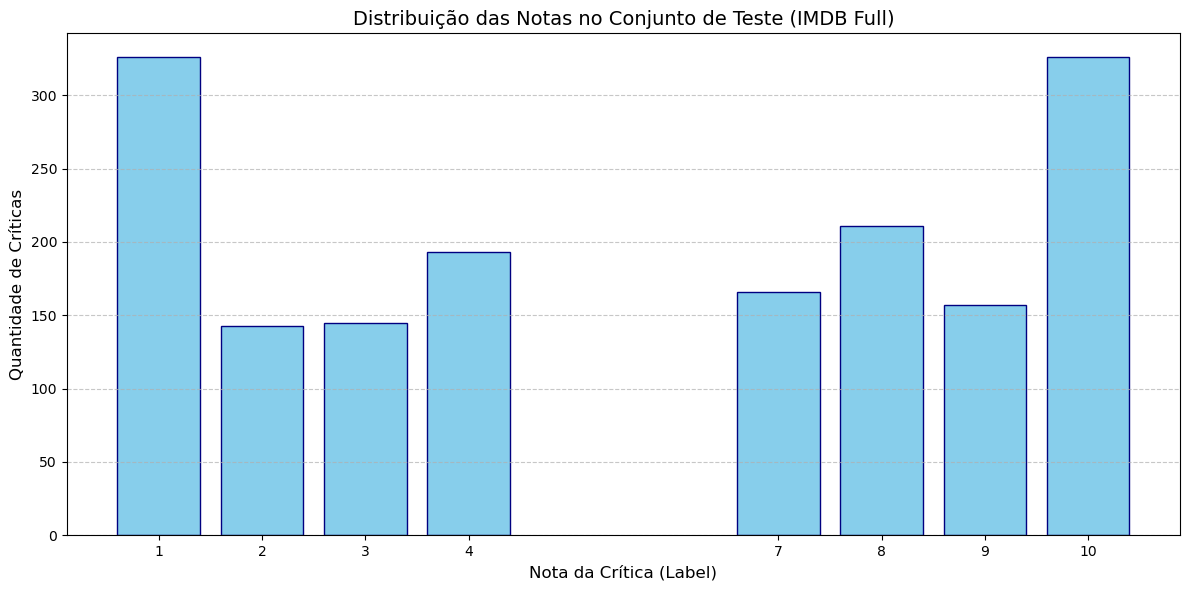

In [10]:
import matplotlib.pyplot as plt

contagem = {}

for nota in y_test:
    # Se a nota já estiver no dicionário, soma 1, senão começa em 1
    contagem[nota] = contagem.get(nota, 0) + 1

# 3. Mostrar os resultados de forma organizada
print("Distribuição das Notas (Labels):")
print("-" * 30)
total = 0
for nota in sorted(contagem.keys()):
    print(f"Nota {nota}: {contagem[nota]} críticas")
    total += contagem[nota]

print("-" * 30)
print(f"Total: {total} críticas")

# 1. Preparar os dados (garantindo a ordem das notas de 1 a 10)
notas_ordenadas = sorted(contagem.keys())
valores = [contagem[nota] for nota in notas_ordenadas]

# 2. Criar a figura
plt.figure(figsize=(12, 6))

# 3. Criar o gráfico de barras
# 'skyblue' é uma cor padrão limpa; 'edgecolor' ajuda na definição das barras
bars = plt.bar(notas_ordenadas, valores, color='skyblue', edgecolor='navy')

# 4. Adicionar os números exatos em cima de cada barra
for bar in bars:
    yval = bar.get_height()
    # plt.text(x, y, texto, ...)
    # plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), 
    #          ha='center', va='bottom', fontsize=10, fontweight='bold')

# 5. Personalizar títulos e eixos
plt.title('Distribuição das Notas no Conjunto de Teste (IMDB Full)', fontsize=14)
plt.xlabel('Nota da Crítica (Label)', fontsize=12)
plt.ylabel('Quantidade de Críticas', fontsize=12)

# Garantir que o eixo X mostre todas as notas de 1 a 10
plt.xticks(notas_ordenadas)

# Adicionar uma linha de grade apenas no eixo Y para facilitar a leitura
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 6. Ajustar layout e exibir
plt.tight_layout()
plt.show()

Plotar as 100 primeiras críticas

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42) # PCA para 2D

X_train_2d = pca.fit_transform(X_train_idf.toarray())
X_test_2d = pca.transform(X_test_idf.toarray())

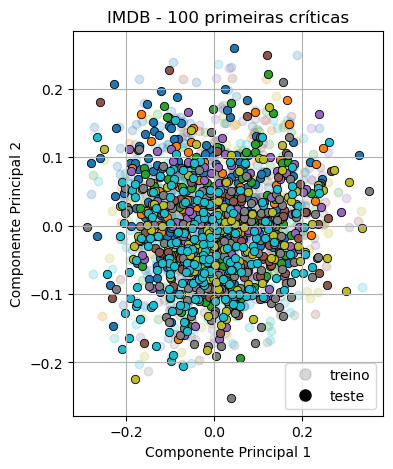

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

def grafico_imdb_pca(X_train_2d, X_test_2d, y_train, y_test):
    classes = sorted(set(y_train))
    cores = plt.cm.tab10(np.linspace(0, 1, len(classes)))

    plt.figure(figsize=(4, 5))

    # TREINO
    for c, cor in zip(classes, cores):
        idx = (y_train == c)
        plt.scatter(X_train_2d[idx, 0], X_train_2d[idx, 1], color=cor, alpha=0.2)

    # TESTE 
    for c, cor in zip(classes, cores):
        idx = (y_test == c)
        plt.scatter(X_test_2d[idx, 0], X_test_2d[idx, 1], color=cor, edgecolors="black", linewidths=0.6)

    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.title("IMDB - 100 primeiras críticas")
    plt.grid(True)

    # Legenda
    legend_elements = [
        Line2D([0], [0],marker='o',color='gray',label='treino',markerfacecolor='gray',markersize=8,alpha=0.3,linestyle='None'),
        Line2D([0], [0],marker='o',color='black',label='teste',markerfacecolor='black',markeredgewidth=1,markersize=8,linestyle='None')
    ]

    plt.legend(handles=legend_elements, loc="best")
    plt.legend(handles=legend_elements, loc="lower right")
    plt.show()

numero_criticas = 1000
grafico_imdb_pca(X_train_2d[:numero_criticas], X_test_2d[:numero_criticas], y_train[:numero_criticas], y_test[:numero_criticas])


#### Logistic Regression

Falta meter aqui o RandomSearch +  as explicações

c:\Users\bigui\miniconda3\envs\env-AA\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy do teste:  0.39112177564487105
              precision    recall  f1-score   support

           1       0.46      0.86      0.60       326
           2       0.30      0.02      0.04       143
           3       0.16      0.04      0.07       145
           4       0.31      0.25      0.28       193
           7       0.23      0.12      0.16       166
           8       0.27      0.21      0.24       211
           9       0.00      0.00      0.00       157
          10       0.42      0.77      0.54       326

    accuracy                           0.39      1667
   macro avg       0.27      0.28      0.24      1667
weighted avg       0.30      0.39      0.31      1667

Confusion Matrix:
 [[280   1   4  16   3   7   0  15]
 [ 96   3   7  18   3   5   0  11]
 [ 79   1   6  29  10   4   0  16]
 [ 71   3  11  48  19  14   1  26]
 [ 20   0   6  19  20  36   2  63]
 [ 24   0   1  10  16  44   3 113]
 [ 13   1   0   5   9  25   0 104]
 [ 23   1   2  10   8  28   3 251]]


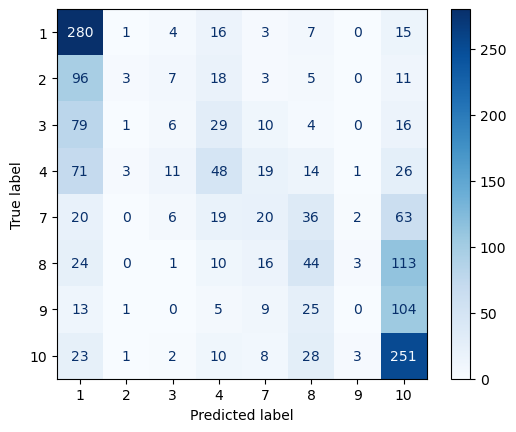

In [8]:
clr = LogisticRegression(max_iter=1000,multi_class="multinomial", random_state=42).fit(X_train_idf, y_train)

predict_clr = clr.predict(X_test_idf)
accuracy_clr = accuracy_score(y_test, predict_clr)

print("Accuracy do teste: ", accuracy_clr)
print(classification_report(y_test, predict_clr))

cm = confusion_matrix(y_test, predict_clr)
print("Confusion Matrix:\n", cm)
fh=ConfusionMatrixDisplay(cm, display_labels=clr.classes_)
fh.plot(cmap=plt.cm.Blues)

#### SVC

Falta meter aqui o RandomSearch +  as explicações

Accuracy do teste:  0.38032393521295743
              precision    recall  f1-score   support

           1       0.53      0.72      0.61       326
           2       0.24      0.14      0.18       143
           3       0.17      0.12      0.14       145
           4       0.32      0.27      0.29       193
           7       0.20      0.18      0.19       166
           8       0.25      0.22      0.23       211
           9       0.21      0.11      0.15       157
          10       0.47      0.66      0.55       326

    accuracy                           0.38      1667
   macro avg       0.30      0.30      0.29      1667
weighted avg       0.34      0.38      0.35      1667

Confusion Matrix:
 [[236  19  15  19   7   8   4  18]
 [ 71  20  16  15   9   4   0   8]
 [ 48  14  18  26  24   4   3   8]
 [ 42  13  23  52  22  19   4  18]
 [ 10   5  19  18  30  39  11  34]
 [ 12   6   5  15  32  46  23  72]
 [  9   3   4   7   9  26  18  81]
 [ 15   5   7  11  17  36  21 214]]


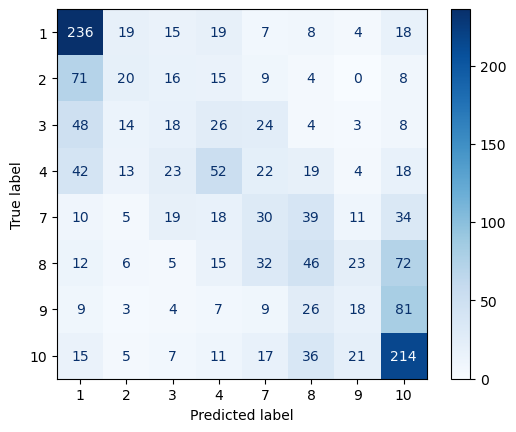

In [9]:
svm = LinearSVC(C=1.0, max_iter=10000).fit(X_train_idf, y_train)

predict_svm = svm.predict(X_test_idf)
accuracy_svm = accuracy_score(y_test, predict_svm)

print("Accuracy do teste: ", accuracy_svm)
print(classification_report(y_test, predict_svm))

cm = confusion_matrix(y_test, predict_svm)
print("Confusion Matrix:\n", cm)
fh=ConfusionMatrixDisplay(cm, display_labels=svm.classes_)
fh.plot(cmap=plt.cm.Blues)

### 2.2.2 - Análise com Regressão Linear

Treinar um modelo para prever a pontuação contínua da crítica. Depois, converter as previsões contínuas do regressor para rótulos de classificação:

valores preditos → mapeados para 1–4 e 7–10.


### 2.2.3 - Análise dos resultados

- desempenho da classificação direta,
- desempenho da classificação derivada da regressão.
Para regressão, medir:
- MAE
- MSE

## 2.3 - Clustering

1. Aplicar K-Means como método base de clustering.
2. Aplicar um segundo método (AgglomerativeClustering) para comparação.
3. Avaliar e comparar os métodos considerando:
    - separação dos clusters (silhouette)
    - distância entre centróides
    - palavras representativas
    - consistência visual (PCA)
    - distribuição dos clusters
4. Investigar o impacto da variação de k no desempenho e interpretação dos clusters.
5. Escolher o método e valor de k mais adequado com base nas métricas.


Para a parte do clustering, vamos aplicar métodos de clustering diferentes e comparar os resultados. Os métodos que vamos aplicar são:
- KMeans
- AgglomerativeClustering

Vamos ainda aplicar PCA para reduzir o numero de dimensões do nosso dataset e ver se isso melhora o desempenho dos nossos métodos de clustering
Para termos uma base de comparação, vamos apenas usar 10 clusters para todos os métodos, e depois vamos avaliar o parametro k e perceber o impacto deste parametro.

Para avaliar o desempenho, vamos utilizar duas métricas retornadas pelas funções: silhouete e inertia. A inertia é uma métrica que mede a distancia dos pontos aos seus clusters atribuidos. Quanto menor for esse valor, mais pertos os pontos estão do seu cluster. Este valor é sensivel ao parametro K, porque ao diminuir o numero de clusters, estamos a colocar mais pontos por cluster, logo a aumentar a _inertia_.

A silhouette é uma métrica que mede se os pontos estão mais próximos ao seu cluster do que a outros clusters vizinhos. É uma métrica que ajuda a perceber se os clusters estão bem separados. Este parametro está situado entre -1 e 1, sendo que valores negativos podem significar que alguns pontos foram mal classificados, perto de 1 pode significar que os clusters estão bem criados, e perto de 0 significa que os clusters podem estar uns em cima dos outros.

Para visualizar, vamos incluir representações com 3 dimensões, que é o máximo que conseguimos representar visualmente. Estas representações é só para perceber se existe núvens de pontos que sejam visiveis, apesar dos clusters terem mais do que 3 dimensões.

In [6]:
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering


def top_words_per_cluster(centers, feature_names, n=15):
    for i, c in enumerate(centers):
        print(f"\nCluster {i}:")
        idx = np.argsort(c)[::-1][:n]
        print(", ".join(feature_names[j] for j in idx))


def show_examples_per_cluster(data, labels, n=3):
    for c in np.unique(labels):
        print(f"\n===== Cluster {c} =====")
        idx = np.where(labels == c)[0][:n]
        for i in idx:
            print(data[i][:300], "\n---")

def plot_clusters(X, labels, title="Clusters"):
    pca = PCA(n_components=3)
    X_3d = pca.fit_transform(X)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        X_3d[:, 0], X_3d[:, 1], X_3d[:, 2],
        c=labels, s=3
    )

    ax.set_title(title)

    plt.show()

# Retirado do https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


k = 10

# Transformar os dados
use_pickled = True
X_transformed = None

if(use_pickled):
    X_transformed = pickle.load(open('X_transformed.pkl','rb'))
else:
    X_transformed = vectorizer.fit_transform(cleaned_data)
    pickle.dump(X_transformed, open('X_transformed.pkl','wb'))
    
    
X_dense = X_transformed.toarray()


### 2.3.1 - Clustering com KMeans

KMeans (k=10)
Inertia: 45861.97552536512
Silhouette Score: 0.0004605975407449647


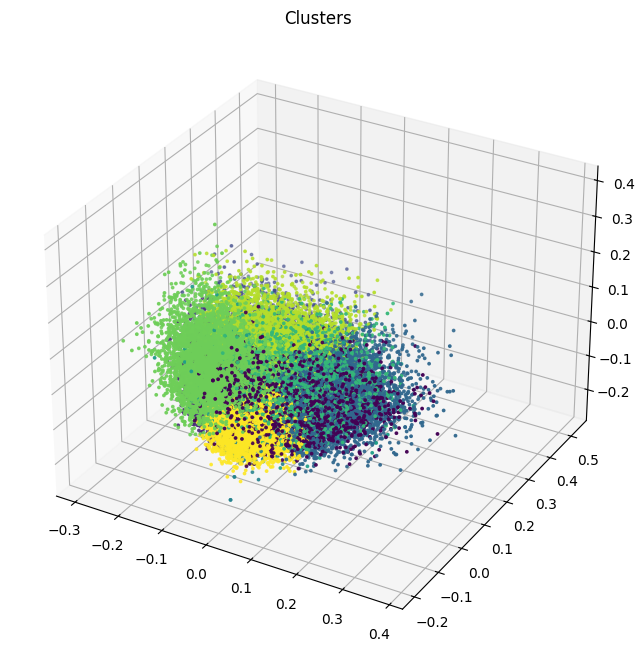

In [7]:
from sklearn.cluster import KMeans
import numpy as np

# número de clusters a testar (ex.: 5)

def kmeans_cluster(k, X):
    print(f"KMeans (k={k})")

    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=5,
        max_iter=1000,
        random_state=42
    )

    kmeans.fit(X)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    inertia = kmeans.inertia_
    sil = None
    
    if k > 1:
        sil = silhouette_score(X, labels)

    print("Inertia:", inertia)
    print("Silhouette Score:", sil)

    return labels, centers, inertia, sil, kmeans



labels_km,centers_km,inertia_km,sil_km, kmeans = kmeans_cluster(k,X_transformed)


plot_clusters(X_transformed, labels_km)

In [ ]:
top_words_per_cluster(centers_km, vectorizer.get_feature_names_out(), 5)

#### 2.3.2.1 K-Means com PCA

Para percebermos o impacto da remoção de dimensões, vamos aplicar PCA para reduzir o numero de componentes que damos como _input_ ao algoritmo K-Means. O objetivo é perceber se o algoritmo beneficia com menos dimensões ou não. Para isso, temos dois métodos à disposição:
- Método PCA, que atua melhor quando os dados estão escalados (ou centrados), e não é muito recomendado para matrizes esparsas. Este método suporta variancias em percentagens.

- Método TruncatedSVD, que é um método melhor optimizado para matrizes esparsas, e que é mais eficiente em termos de memória. Este método não suporta variancias em percentagens, pelo que temos de aplicar um numero fixo de componentes.

No nosso caso, estamos a trabalhar com matrizes esparsas, pelo que a utilização direta do PCA poderia causar problemas de perfomance. Para usar o PCA, ainda teriamos primeiro de aplicar escalamento (através do StandardSscaler) numa matriz esparsa (com muitos 0's), pelo que o _TruncatedSVD_ acaba por ser a opção mais eficiente para o nosso caso.

In [ ]:
def kmeans_cluster_pca(k, X, n_components):
    print(f"KMeans com PCA (k={k}, n_components={n_components})")

    svd = TruncatedSVD(
        n_components=n_components,
        random_state=42
    )

    X_used = svd.fit_transform(X)

    # print(f"PCA components: {pca.n_components_}")

    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=5,
        max_iter=1000,
        random_state=42
    )

    labels = kmeans.fit_predict(X_used)
    centers = kmeans.cluster_centers_

    inertia = kmeans.inertia_
    sil = None

    if k > 1:
        sil = silhouette_score(X_used, labels)

    print("Inertia:", inertia)
    print("Silhouette Score:", sil)

    return labels, centers, inertia, sil, X_used, kmeans



labels_km_pca, centers_km_pca, inertia_km_pca, sil_km_pca, X_used_km_pca, kmeans_km_pca = kmeans_cluster_pca(k,X_transformed,100)
labels_km_pca, centers_km_pca, inertia_km_pca, sil_km_pca, X_used_km_pca, kmeans_km_pca = kmeans_cluster_pca(k,X_transformed,200)
labels_km_pca, centers_km_pca, inertia_km_pca, sil_km_pca, X_used_km_pca, kmeans_km_pca = kmeans_cluster_pca(k,X_transformed,300)

KMeans com PCA (k=10, n_components=100)
Inertia: 6466.548755357319
Silhouette Score: 0.026017058392246623
KMeans com PCA (k=10, n_components=200)
Inertia: 9776.954912108764
Silhouette Score: 0.013494407365104733
KMeans com PCA (k=10, n_components=300)
Inertia: 12277.534491746255
Silhouette Score: 0.009308221317572777


Conseguimos então perceber que, com PCA, os clusters ficam ligeramente melhores (o silhouette score fica mais perto de 0). Ao aumentar o numero de componentes, os clusters começam a ficar menos definidos, e a distancia dos pontos ao centros dos clusters aumenta, talvez porque estamos a dar mais dimensões ao algoritmo de k-means. 

Sem PCA, temos os seguintes dados (retirados do _output_ acima):
- Inertia: 41794.0573403712
- Silhouette Score: -0.015088521462772205

Pelo que as melhorias são ligeiramente superiores a não usar PCA. Neste caso, não "compensa" usar PCA, uma vez que não traz melhorias muito significativas.

### 2.3.2 - Clustering com AgglomerativeClustering

- Simple produz menos clusters
- Complete consegue computar mais clusters

AgglomerativeClustering (k=10)
Silhouette Score: -0.002065373644258619


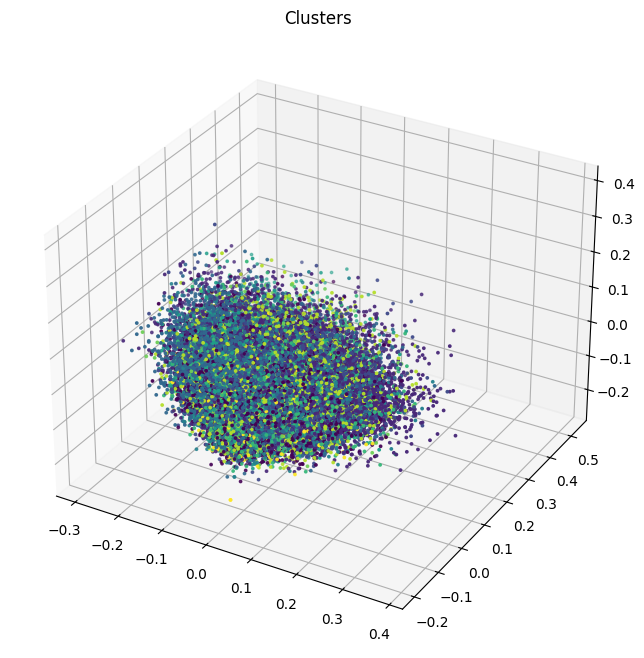

In [ ]:

def agg_cluster(k, X):
    print(f"AgglomerativeClustering (k={k})")
    
    agg = AgglomerativeClustering(
        n_clusters=k,
        linkage="complete"        
    )

    a = agg.fit(X)
    labels = a.labels_
    sil = None
    if(k>1):
        sil = silhouette_score(X, labels)
        print("Silhouette Score:", sil)


    # Calcular centro de cada cluster
    centers = []
    for c in range(k):
        idx = np.where(labels == c)[0]
        centers.append(X[idx].mean(axis=0))

    centers = np.array(centers).squeeze()

    return labels, centers, sil

# Sem PCA
# 10k -> 1m30s
# 30k -> 13m14s
# tudo -> 40ms
labels_agg,centers_agg,sil_agg = agg_cluster(k,X_dense)
plot_clusters(X_dense, labels_agg)


#### 2.3.2.1 Cluster Hierarquico com PCA

AgglomerativeClustering (k=10)
Silhouette Score: 0.026125354244027205


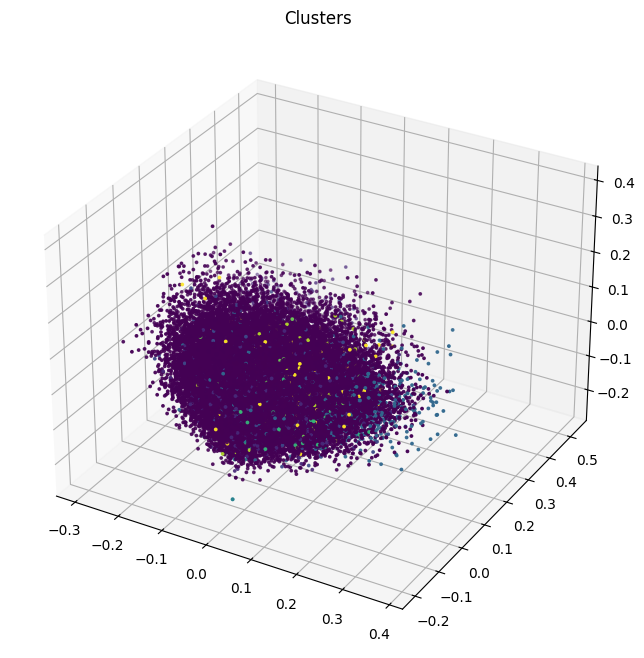

In [ ]:
# 300 componentes
svd = TruncatedSVD(
    n_components=300,
    random_state=42
)

X_svd = svd.fit_transform(X_transformed)

# Com PCA
# 10k com SVD -> 17s
# 30k (SVD) -> 2m30s
# tudo (SVD) -> 9m30s
labels_agg,centers_agg,sil_agg = agg_cluster(k,X_svd)
plot_clusters(X_svd, labels_agg)


#### 2.3.2.2 Dendrograma

In [ ]:
Link=AgglomerativeClustering(n_clusters=None, linkage="complete",distance_threshold=0).fit(X_dense)
plot_dendrogram(Link, truncate_mode="level", p=5)

### 2.3.3 - Comparação de clusters e impacto do parametro K

Com os resultados acima, conseguimos fazer comparar os clusters que são feitos por ambos os algoritmos. O valor chave que vamos usar é métrica silhouete, visto que o algoritmo k-medias é uma algoritmo baseado em distancias, em que cada ponto é atribuido ao cluster mais perto, e os centroides são recalculados até convergir, e o AgglomerativeClustering é uma algoritmo que não usa centroides, mas que agrupa pontos em clusters e converge quando só existe apenas um único grupo. Por causa dos algoritmos terem modos de funcionamento diferentes, a unica métrica comum entre ambos é a métrica de sihouette, e é essa que vamos analisar.

Em ambos os outputs, o score é sensivelmetne perto de 0, que indica que os clusters em ambos os algoritmos estão sobrepostos. As visualizações em 3D acima feitas já demonstram exatamente isso. Outra nota interessante é que usar apenas as dimensões com mais variação (PCA) não traz melhorias significativas em termos de algoritmo, mas faz os algoritmos convergir mais rápido, devido a redução geral dos dados que alimentamos aos algoritmos.

Uma coisa que notámos durante o desenvolvilemti é que o AgglomerativeClustering usa muito a memória RAM (ocupando quase 90%) porque como é recursivo, tem que manter em memoria as relações entrer os pontos (os agrupamentos), enquanto que o K-Means usa mais CPU, porque tem calcular distancias entre todos os pontos do dataset. Ainda assim, o K-Means converge mais rápido que o heiraquico.

Outra diferença grande entre o AgglomerativeClustering e o K-Means é como lidam com o parâmetro K, uma vez que no K-Means o número de clusters tem de ser definido na chamada, enquanto no clustering hierárquico esse valor pode ser determinado após a construção do dendrograma. Por esse motivo, vamos só analisar o impacto do parametro K no K-Means e enterpretar os resultados 

In [ ]:
def evaluate_k_values(X, k_list):
    sil_scores = []
    inertia_scores = []
    print(k_list)
    
    for k in k_list:
        labels, centers, inertia, sil, kmeans = kmeans_cluster(k,X)
        sil_scores.append(sil)
        inertia_scores.append(inertia)

    return sil_scores, inertia_scores

k_list = range(1,20+1, 2)
sil_scores, inertia_scores = evaluate_k_values(X_transformed,k_list)

plt.plot(k_list, inertia_scores, 'bx-')
plt.title("")
plt.xticks(k_list)  # change step size as needed
plt.grid()
plt.show()

plt.plot(k_list, sil_scores, 'bx-')
plt.xticks(k_list)  # change step size as needed
plt.grid()
plt.show()

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
range(1, 21, 2)
KMeans (k=1)
Inertia: 46834.435257466466
Silhouette Score: None
KMeans (k=3)
Inertia: 46403.372887036865
Silhouette Score: 0.0022608186105475218
KMeans (k=5)
Inertia: 46162.77139472605
Silhouette Score: 0.002673961418140941
KMeans (k=7)
Inertia: 46019.26153439336
Silhouette Score: 0.0004349413648338797
KMeans (k=9)
Inertia: 45901.2970822577
Silhouette Score: 0.0009670043384092165
KMeans (k=11)
Inertia: 45829.86573248065
Silhouette Score: -0.00024250042187833973
KMeans (k=13)
Inertia: 45767.22861571128
Silhouette Score: 4.6478071293222226e-05
KMeans (k=15)
Inertia: 45690.21173704137
Silhouette Score: 0.0013462425908069187
KMeans (k=17)


# 3 - Conclusões

# 4 - Bibliografia

- https://www.reddit.com/r/statistics/comments/180nm8y/question_pca_for_visualizing_clusters/
- https://pca4ds.github.io/pca-and-clustering.html
- https://stackoverflow.com/questions/35160256/how-do-i-output-lists-as-a-table-in-jupyter-notebook
- https://www.kaggle.com/code/sabanasimbutt/clustering-visualization-of-clusters-using-pca
- https://www.kaggle.com/code/hasanaltunay/agglomerative-clustering-dendrograms-pca
- https://projectai.in/projects/ac30fffa-f885-440c-a9a4-54228fdfebc9/tasks/22ec2a03-6e13-43be-9f45-889382db2d78?tab=task
- https://apxml.com/courses/nlp-fundamentals/chapter-3-nlp-text-classification/hyperparameter-tuning-text-models
- https://365datascience.com/tutorials/python-tutorials/pca-k-means/
- https://www.kaggle.com/code/albeffe/text-clustering-tfidf-pca-beginner-tutorial
- https://stats.stackexchange.com/questions/239481/difference-between-scikit-learn-implementations-of-pca-and-truncatedsvd